In [75]:
import pandas as pd
import re
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import scipy.stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import shapiro

In [76]:
df = pd.read_csv("covid-hospit-2023-03-31-18h01.csv", sep = ';')
df.head()

,dep,sexe,jour,hosp,rea,HospConv,SSR_USLD,autres,rad,dc
0,01,0,2020-03-18,2,0,NaN,NaN,NaN,1,0
1,01,1,2020-03-18,1,0,NaN,NaN,NaN,1,0
2,01,2,2020-03-18,1,0,NaN,NaN,NaN,0,0
3,02,0,2020-03-18,41,10,NaN,NaN,NaN,18,11
4,02,1,2020-03-18,19,4,NaN,NaN,NaN,11,6


In [77]:
df = df.drop(["dep","sexe","rea","HospConv","SSR_USLD","autres","rad","dc"],axis=1)

In [78]:
df = df.dropna()
df = df.drop_duplicates()
df

,jour,hosp
0,2020-03-18,2
1,2020-03-18,1
3,2020-03-18,41
4,2020-03-18,19
5,2020-03-18,22
...,...,...
338223,2023-03-31,252
338224,2023-03-31,317
338225,2023-03-31,343
338226,2023-03-31,144


In [79]:
df["jour"] = pd.to_datetime(df["jour"])
df = df.set_index("jour")

In [80]:
df = df.groupby(pd.Grouper(freq='D')).sum()
df.shape

(1109, 1)

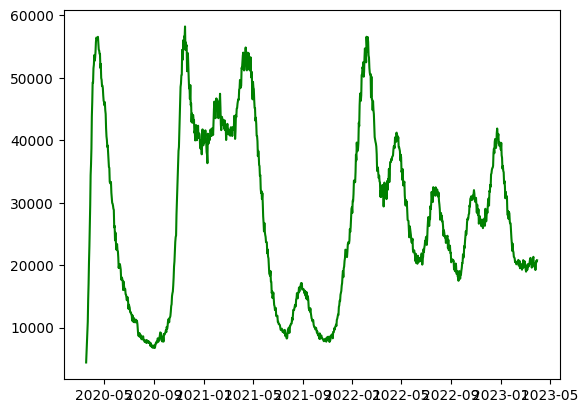

In [81]:
plt.plot(df,color="green")
plt.show()

In [82]:
adfuller(df)

(-3.157110581401882,
 0.02260542823028116,
 19,
 1089,
 {'1%': -3.436369082756128,
  '5%': -2.8641976875421524,
  '10%': -2.5681850407995137},
 17857.397480977306)

p < 0.05 donc la série est stationnaire.

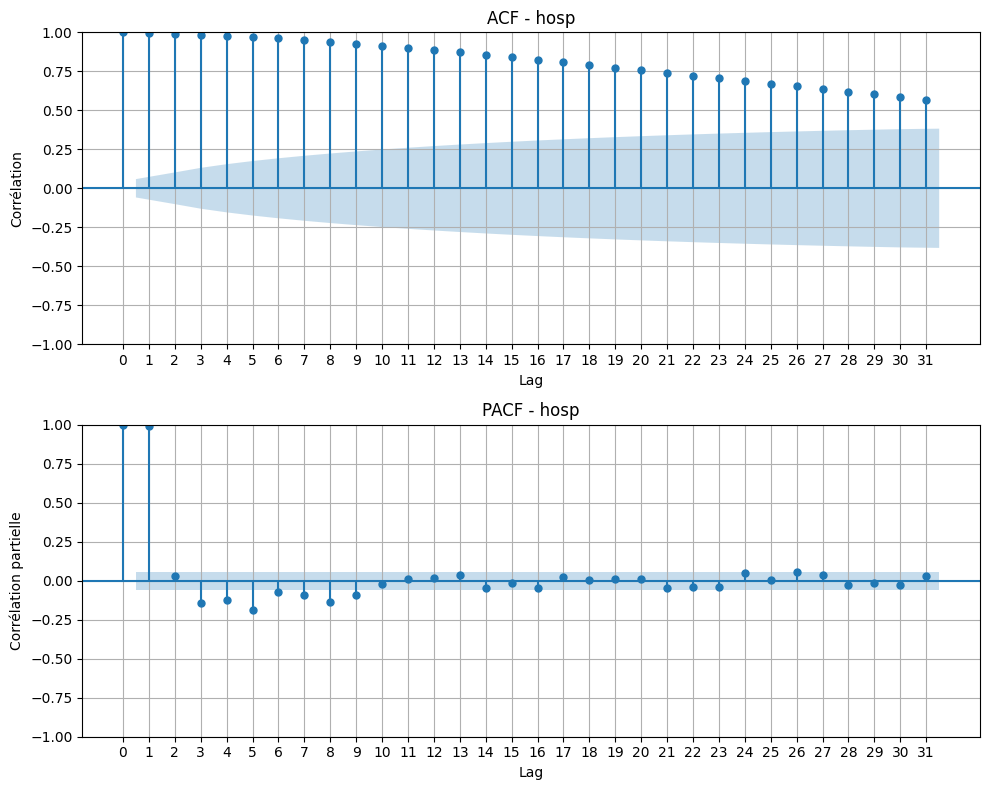

In [83]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(df["hosp"], lags=31, zero=True, ax=ax1)
ax1.set_title('ACF - hosp')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)

ax1.set_xticks(np.arange(0, 32, 1))

plot_pacf(df["hosp"], lags=31, zero=True, ax=ax2)
ax2.set_title('PACF - hosp')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation partielle')
ax2.grid(True)

ax2.set_xticks(np.arange(0, 32, 1))

plt.tight_layout()

plt.show()

p = 1, d = 0, q = 31

In [84]:
train_data = df["hosp"][:-100]
test_data = df["hosp"][-100:]
model = ARIMA(train_data, order=(1,0,31))
model_fit = model.fit()

In [85]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   hosp   No. Observations:                 1009
Model:                ARIMA(1, 0, 31)   Log Likelihood               -8321.124
Date:                Thu, 13 Mar 2025   AIC                          16710.249
Time:                        16:23:29   BIC                          16877.417
Sample:                    03-18-2020   HQIC                         16773.757
                         - 12-21-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.795e+04   4607.237      6.067      0.000    1.89e+04     3.7e+04
ar.L1          0.9752      0.009    107.398      0.000       0.957       0.993
ma.L1         -0.3070      0.029    -10.639      0.0

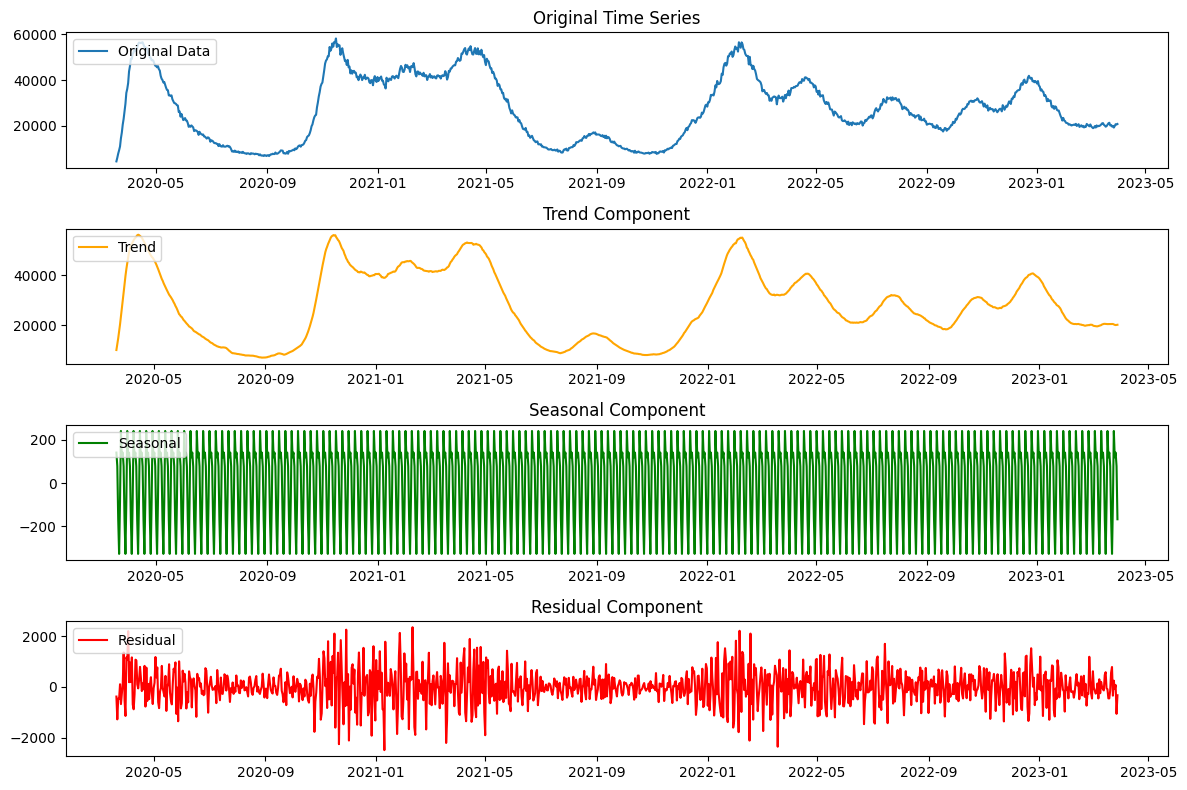

In [86]:
result = seasonal_decompose(df['hosp'], model='additive')

trend = result.trend
seasonal = result.seasonal
residual = result.resid

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(df['hosp'], label='Original Data')
plt.legend(loc='upper left')
plt.title('Original Time Series')

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual', color='red')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

In [87]:
predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

test_mse = mean_squared_error(test_data, predictions)
print(test_mse)

49550294.542471245


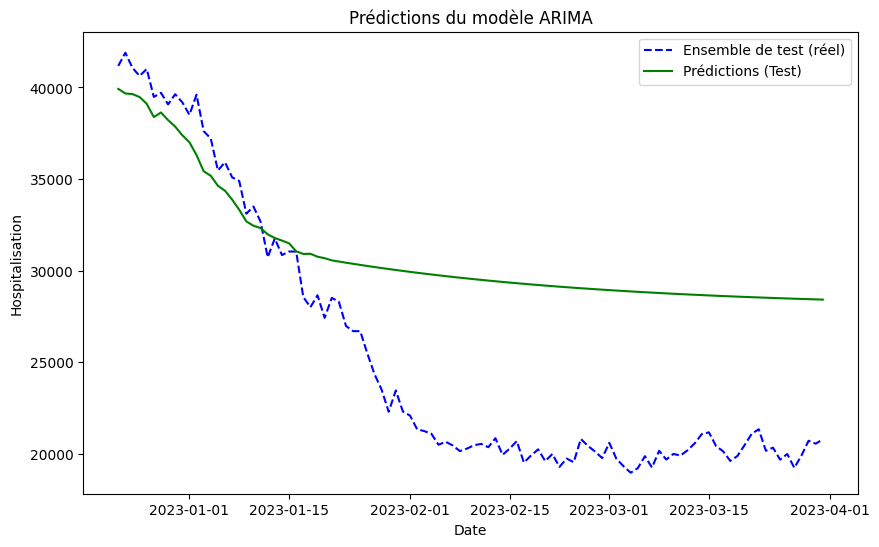

In [88]:
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data.values, label='Ensemble de test (réel)', color='blue', linestyle='--')
plt.plot(test_data.index, predictions, label='Prédictions (Test)', color='green')

plt.xlabel('Date')
plt.ylabel('Hospitalisation')
plt.title('Prédictions du modèle ARIMA')
plt.legend()
plt.show()

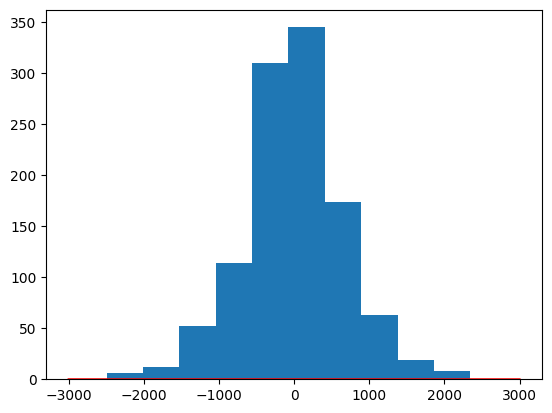

In [89]:
mean = np.mean(residual)
std = np.std(residual)

x_min = -3000
x_max = 3000
x = np.linspace(x_min, x_max, 100000)
y = scipy.stats.norm.pdf(x,mean,std)
plt.plot(x,y, color='red')

plt.hist(residual)
plt.show()